# Facial Expression Classification

### Using Computer Vision for Facial Expression Classification

This project investigates the use of computer vision techniques to build a classifier that can identify which facial expression is present, in a picture of a human face.

A deep learning approach will be taken to this problem, investigating the use of convolutional neural networks (CNNs). 

A simple benchmark CNN will first be investigated, followed by a more complex and deep network.

In addition, the use of pre-existing architectures for the [ImageNet challenge](http://www.image-net.org/challenges/LSVRC/) will be explored to aid performance in the facial expression classification problem. 






In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from keras.datasets import mnist
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.callbacks import ModelCheckpoint  
from keras.preprocessing.image import ImageDataGenerator
from utility_functions import *

from keras import losses
from keras import backend as K
from keras import applications
from keras import optimizers

%matplotlib inline

Using TensorFlow backend.


### Reading the Data

The dataset can be obtained from [here](https://www.kaggle.com/c/challenges-in-representation-learning-facial-expression-recognition-challenge).

In [2]:
# Allow for use of a section of the dataset to avoid large processing times
use_section_data = False
smaller_section_data = False

if use_section_data:
    data = pd.read_csv("section_fer2013.csv")    
    if smaller_section_data:
        data = pd.read_csv("smaller_section_fer2013.csv")
else:
    data = pd.read_csv("fer2013.csv")

# Create separate data structures for the labels and the features    
labels = data['emotion']
features = data.drop(['emotion','Usage'], axis=1, inplace=False)

### Pre-Processing the Data

The raw data is in .csv format, with every pixel value listed in a single cell, for each image, separated by spaces.

Below, each pixel value is separated, to be an individual value in a Python list, within a Data Frame.

In addition, the data will be converted to a tensor format.

In [3]:
list_of_pixels = []
# Extract the pixel values for each image in the .csv file and put them into a list
for i in features['pixels']:
    list_of_pixels.append(i.split())

features.drop('pixels',axis=1,inplace=True)
features['pixels'] = pd.Series(list_of_pixels)

Of all of the data that has been imported, 20% will be used for training, 10% for validation, and 70% for training.

In [4]:
from sklearn.model_selection import train_test_split

# Split the total data into three sections: 80% training, 10% validation, and 20% testing
X_train, X_test, y_train, y_test = train_test_split(features,labels,test_size = 0.2, random_state=0)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.125, random_state=0)

### Sample Visualization

A few of the images from the dataset will be plotted below to ensure the data has been correctly processed.

In [5]:
# Take a few sample images to provide a visualization
samples = dataframe_to_nparray(features,48)

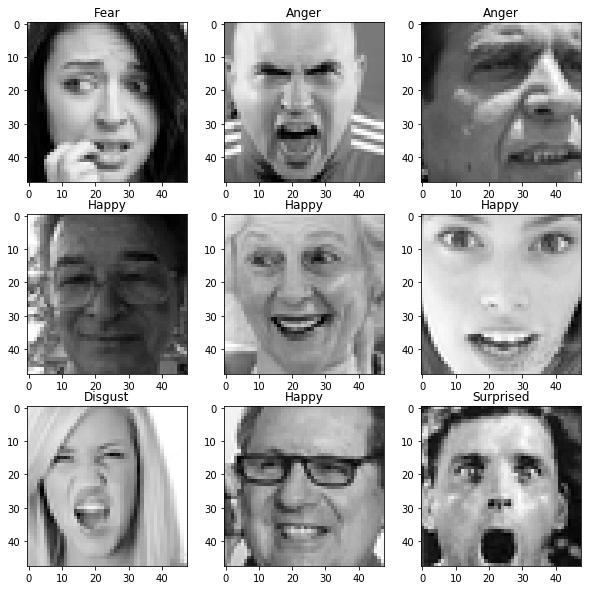

In [6]:
seed_number = 21
fig = plt.figure(figsize=(10, 10))
num_rows = 3
num_columns = 3
hardcoded_labels = ["Fear", "Anger", "Anger", "Happy", "Happy",
                   "Happy", "Disgust", "Happy", "Surprised"]

for i in range(num_rows*num_columns):
    ax = fig.add_subplot(num_rows,num_columns,i + 1)
    ax.imshow(samples[seed_number + i].reshape(48,48), cmap='gray')
    ax.title.set_text(hardcoded_labels[i])

### Frequency of Expressions

The distribution of how many times each expression appears in the dataset is important to inform what metrics are suitable for assessing the classifier. Below a bar graph showing the relative frequencies of each expression is shown.

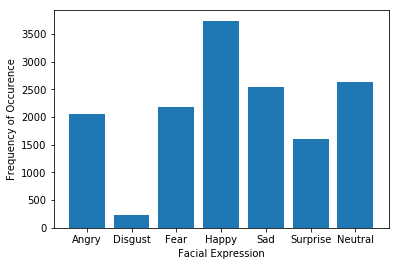

In [7]:
frequency_list = np.zeros(7)
for label in labels:
    frequency_list[int(label)] += 1
    
# Parse the numbers that correspond to different emotions in the dataset
emotion_indices = range(1,8)
x_axis_labels = ['Angry','Disgust','Fear','Happy','Sad','Surprise', 'Neutral']

bar = plt.bar(emotion_indices, frequency_list, align='center')
plt.xticks(emotion_indices, x_axis_labels )
plt.xlabel("Facial Expression")
plt.ylabel("Frequency of Occurence")
plt.show()

In [8]:
train_tensors = dataframe_to_nparray(X_train,48).astype('float32')/255
valid_tensors = dataframe_to_nparray(X_val,48).astype('float32')/255
test_tensors = dataframe_to_nparray(X_test,48).astype('float32')/255

train_targets = np.array(pd.get_dummies(y_train))
valid_targets = np.array(pd.get_dummies(y_val))
test_targets = np.array(pd.get_dummies(y_test))

In [9]:
# For the fer2013 dataset obtained from Kaggle, each picture is a uniform size of 48x48
img_width = 48
img_height = 48

### Evaluation Metrics

Due to the uneven distribution of facial expressions in the dataset, illustrated above, accuracy alone is not a suitable measure of classifier performance. Instead <b>categorical cross entropy loss</b> will be used to rank classifiers.


### Baseline Model

First, a simple CNN will be used to build a classifier, to which others can be compared. The baseline comprises only of one convolutional layer with 16 filters and is expected to pick up basic features in the faces that will give it some degree of accuracy with the classification task


In [10]:
model_baseline = Sequential()
model_baseline.add(Conv2D(filters=16, kernel_size=2, padding='same', activation='relu', input_shape=(48,48,1)))
model_baseline.add(MaxPooling2D(pool_size=2))
model_baseline.add(Flatten())
model_baseline.add(Dense(100, activation='relu'))
model_baseline.add(Dense(7, activation='softmax'))

model_baseline.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 48, 48, 16)        80        
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 24, 24, 16)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 9216)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 100)               921700    
_________________________________________________________________
dense_2 (Dense)              (None, 7)                 707       
Total params: 922,487
Trainable params: 922,487
Non-trainable params: 0
_________________________________________________________________


In [11]:
model_baseline.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

In [12]:
epochs = 20
# Only use the model weights in the epoch with the least validation loss
checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.baseline.hdf5', 
                               verbose=1, save_best_only=True)
history_baseline = model_baseline.fit(train_tensors, train_targets, 
          validation_data=(valid_tensors, valid_targets),
          epochs=epochs, batch_size=20, callbacks=[checkpointer], verbose=1)

Train on 10499 samples, validate on 1500 samples
Epoch 1/20
10499/10499 [==============================] - 10s 989us/step - loss: 1.7542 - acc: 0.2956 - val_loss: 1.6436 - val_acc: 0.3707
Epoch 2/20
10499/10499 [==============================] - 7s 666us/step - loss: 1.5633 - acc: 0.3978 - val_loss: 1.5970 - val_acc: 0.3807
Epoch 3/20
10499/10499 [==============================] - 7s 682us/step - loss: 1.4767 - acc: 0.4394 - val_loss: 1.5726 - val_acc: 0.4053
Epoch 4/20
10499/10499 [==============================] - 7s 660us/step - loss: 1.4002 - acc: 0.4714 - val_loss: 1.5516 - val_acc: 0.4153
Epoch 5/20
10499/10499 [==============================] - 7s 642us/step - loss: 1.3272 - acc: 0.5036 - val_loss: 1.5686 - val_acc: 0.3960
Epoch 6/20
10499/10499 [==============================] - 7s 648us/step - loss: 1.2611 - acc: 0.5318 - val_loss: 1.5887 - val_acc: 0.3973
Epoch 7/20
10499/10499 [==============================] - 7s 679us/step - loss: 1.1952 - acc: 0.5530 - val_loss: 1.5650 - 

In [13]:
model_baseline.load_weights('saved_models/weights.best.baseline.hdf5')

In [14]:
print("Test accuracy: %.4f%% " % get_model_accuracy(model_baseline, test_tensors, test_targets))

Test accuracy: 43.2333% 


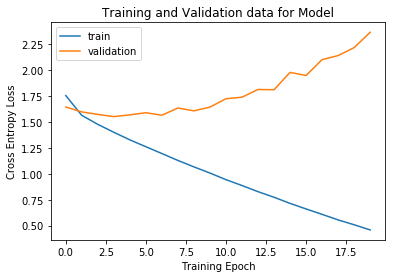

In [15]:
#print(history_baseline.history.keys())
# summarize history for accuracy
plot_model_history(history_baseline, save_file = "baseline.png")

In [16]:
predictions_np = get_predictions_tensor(model_baseline, test_tensors)
print("Average categorical cross entropy: ", manual_total_cce(predictions_np, test_targets))

Average categorical cross entropy:  1.498257755944738


### Advanced Model

Below, a more complex CNN architecture will be investigated. This model contains a higher number of convolutional layers and filters. It is expected this architecture will pick up more complex features in the image that will be useful for classifying what the correct facial expression is.

### Image Augmentation




A high performance classifier for this task needs to have both rotational and translational invariance. To achieve this, image augmentation will be used, whereby images used for training are flipped and shifted randomly.

In [27]:
from keras.preprocessing.image import ImageDataGenerator

def augment_data(train_tensors_input, valid_tensors_input, shift_width=0.1, shift_height=0.1, flip_hor=True,
                flip_vert=False):
    
    # Specify the ways in which image augmentation will be performed
    datagen_train = ImageDataGenerator(
        width_shift_range = shift_width,
        height_shift_range = shift_height,
        horizontal_flip = flip_hor,
        vertical_flip = flip_vert )

    datagen_valid = ImageDataGenerator(
        width_shift_range = shift_width,
        height_shift_range = shift_height,
        horizontal_flip = flip_hor,
        vertical_flip = flip_vert )

    datagen_train.fit(train_tensors_input)
    datagen_valid.fit(valid_tensors_input)
    
    return (datagen_train, datagen_valid)  

In [28]:
(datagen_train, datagen_valid) = augment_data(train_tensors, valid_tensors)

In [29]:
model = Sequential()
model.add(Conv2D(filters=16, kernel_size=2, padding='same', activation='relu', input_shape=(48,48,1)))
model.add(MaxPooling2D(pool_size=2))
model.add(Conv2D(filters=32, kernel_size=2, padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Conv2D(filters=64, kernel_size=2, padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Flatten())
model.add(Dense(100, activation='relu'))
model.add(Dense(7, activation='softmax'))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 48, 48, 16)        80        
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 24, 24, 16)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 24, 24, 32)        2080      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 12, 12, 32)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 12, 12, 64)        8256      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 6, 6, 64)          0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 2304)              0         
__________

In [30]:
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

In [31]:
epochs = 50
checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.from_scratch_augmentation.hdf5', 
                               verbose=1, save_best_only=True)
#Training using image augmentation
batch_size = 20
history_advanced = model.fit_generator(datagen_train.flow(train_tensors, train_targets, batch_size=batch_size),
                    steps_per_epoch=train_tensors.shape[0] // batch_size,
                    epochs=epochs, verbose=1, callbacks=[checkpointer],
                    validation_data=datagen_valid.flow(valid_tensors, valid_targets, batch_size=batch_size),
                    validation_steps=valid_tensors.shape[0] // batch_size)

Epoch 1/50
1256/1256 [==============================] - 11s - loss: 1.7157 - acc: 0.3090 - val_loss: 1.6967 - val_acc: 0.3282
Epoch 2/50
1256/1256 [==============================] - 10s - loss: 1.5657 - acc: 0.3921 - val_loss: 1.5042 - val_acc: 0.4217
Epoch 3/50
1256/1256 [==============================] - 10s - loss: 1.4590 - acc: 0.4389 - val_loss: 1.4303 - val_acc: 0.4505
Epoch 4/50
1256/1256 [==============================] - 10s - loss: 1.4030 - acc: 0.4647 - val_loss: 1.4004 - val_acc: 0.4660
Epoch 5/50
1256/1256 [==============================] - 10s - loss: 1.3562 - acc: 0.4817 - val_loss: 1.3532 - val_acc: 0.4797
Epoch 6/50
1256/1256 [==============================] - 10s - loss: 1.3249 - acc: 0.4907 - val_loss: 1.3428 - val_acc: 0.4844
Epoch 7/50
1256/1256 [==============================] - 10s - loss: 1.2983 - acc: 0.5066 - val_loss: 1.3643 - val_acc: 0.4615
Epoch 8/50
1256/1256 [==============================] - 10s - loss: 1.2830 - acc: 0.5116 - val_loss: 1.2704 - val_acc:

In [32]:
model.load_weights('saved_models/weights.best.from_scratch_augmentation.hdf5')

In [33]:
# get index of predicted facial expression for test set images
print("Test accuracy: %.4f%% " % get_model_accuracy(model, test_tensors, test_targets))

Test accuracy: 56.0741% 


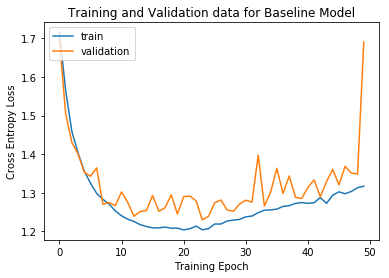

In [34]:
#print(history_advanced.history.keys())
# summarize history for accuracy
plot_model_history(history_advanced, save_file = "advanced.png")

In [36]:
predictions_np = get_predictions_tensor(model, test_tensors)
print("Average categorical cross entropy: ", manual_total_cce(predictions_np, test_targets))

Average categorical cross entropy:  1.18288026919212


### Transfer Learning

It is suitable to explore the use of other CNN architectures that have been used for other computer vision applications. Below, a transfer learning approach using the VGG-19 architecture will be explored.

In [18]:
# Use the same splits of data for the transfer learning approach
X_train_transf, X_test_transf, X_val_transf = X_train, X_test, X_val
y_train_transf, y_test_transf, y_val_transf = y_train, y_test, y_val
sample = dataframe_to_nparray(X_train_transf, 48, reshape=False)

In [19]:
# Creating transfer tensors, which will have a value for each RGB channel

train_tensors_transf = dataframe_to_nparray(X_train_transf,48,reshape=False, triple_channels=True).astype('float32')/255
valid_tensors_transf = dataframe_to_nparray(X_val_transf,48, reshape=False, triple_channels=True).astype('float32')/255
test_tensors_transf = dataframe_to_nparray(X_test_transf,48, reshape=False, triple_channels=True).astype('float32')/255

train_targets_transf = np.array(pd.get_dummies(y_train_transf))
valid_targets_transf = np.array(pd.get_dummies(y_val_transf))
test_targets_transf = np.array(pd.get_dummies(y_test_transf))

In [39]:
img_width, img_height = 48, 48
batch_size = 16
epochs = 50
model = applications.VGG19(weights = "imagenet", include_top=False, input_shape = (img_width, img_height, 3))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 48, 48, 3)         0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 48, 48, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 48, 48, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 24, 24, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 24, 24, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 24, 24, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 12, 12, 128)       0         
__________

In [40]:
# Image augmentation for transfer model

(datagen_train_transf, datagen_valid_transf) = augment_data(train_tensors_transf, valid_tensors_transf)

In [41]:
# Change this code to freeze some of the layers of the VGG-19 model with the pre-trained weights
#for layer in model.layers:
#    layer.trainable = False

In [42]:
# The code below is closely based on examples provided by Prakash Jay, Machine Learning Mastery
# https://towardsdatascience.com/transfer-learning-using-keras-d804b2e04ef8

x = model.output
x = Flatten()(x)
x = Dense(1024, activation="relu")(x)
x = Dropout(0.5)(x)
x = Dense(1024, activation="relu")(x)
x = Dropout(0.5)(x)
x = Dense(1024, activation="relu")(x)
x = Dropout(0.5)(x)
x = Dense(1024, activation="relu")(x)
x = Dropout(0.5)(x)
predictions = Dense(7, activation="softmax")(x)
# creating the final model 
model_final = Model(input = model.input, output = predictions)
# compile the model 
model_final.compile(loss = "categorical_crossentropy", optimizer = optimizers.SGD(lr=0.0001, momentum=0.9), metrics=["accuracy"])

model_final.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 48, 48, 3)         0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 48, 48, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 48, 48, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 24, 24, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 24, 24, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 24, 24, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 12, 12, 128)       0         
__________

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:15: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`
  from ipykernel import kernelapp as app


In [43]:
checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.transfer_example_six.hdf5', 
                               verbose=1, save_best_only=True)
history_transfer = model_final.fit_generator(datagen_train_transf.flow(train_tensors_transf, train_targets_transf, batch_size=batch_size),
                    steps_per_epoch=train_tensors_transf.shape[0] // batch_size,
                    epochs=epochs, verbose=1, callbacks=[checkpointer],
                    validation_data=datagen_valid_transf.flow(valid_tensors_transf, valid_targets_transf, batch_size=batch_size),
                    validation_steps=valid_tensors_transf.shape[0] // batch_size)

Epoch 1/50
1570/1570 [==============================] - 180s - loss: 1.8474 - acc: 0.2222 - val_loss: 1.7769 - val_acc: 0.2419
Epoch 2/50
1570/1570 [==============================] - 214s - loss: 1.7253 - acc: 0.2766 - val_loss: 1.7014 - val_acc: 0.3465
Epoch 3/50
1570/1570 [==============================] - 221s - loss: 1.6459 - acc: 0.3287 - val_loss: 1.6469 - val_acc: 0.3885
Epoch 4/50
1570/1570 [==============================] - 222s - loss: 1.5899 - acc: 0.3671 - val_loss: 1.5813 - val_acc: 0.4055
Epoch 5/50
1570/1570 [==============================] - 222s - loss: 1.5441 - acc: 0.4032 - val_loss: 1.5063 - val_acc: 0.4251
Epoch 6/50
1570/1570 [==============================] - 221s - loss: 1.5078 - acc: 0.4213 - val_loss: 1.4664 - val_acc: 0.4430
Epoch 7/50
1570/1570 [==============================] - 225s - loss: 1.4713 - acc: 0.4297 - val_loss: 1.4549 - val_acc: 0.4481
Epoch 8/50
1570/1570 [==============================] - 224s - loss: 1.4428 - acc: 0.4402 - val_loss: 1.4120 - 

1570/1570 [==============================] - 222s - loss: 1.0685 - acc: 0.6051 - val_loss: 1.1685 - val_acc: 0.5676
Epoch 27/50
1570/1570 [==============================] - 218s - loss: 1.0545 - acc: 0.6147 - val_loss: 1.1408 - val_acc: 0.5905
Epoch 28/50
1570/1570 [==============================] - 208s - loss: 1.0328 - acc: 0.6233 - val_loss: 1.1508 - val_acc: 0.5849
Epoch 29/50
1570/1570 [==============================] - 213s - loss: 1.0209 - acc: 0.6278 - val_loss: 1.1192 - val_acc: 0.5947
Epoch 30/50
1570/1570 [==============================] - 211s - loss: 1.0057 - acc: 0.6365 - val_loss: 1.1351 - val_acc: 0.5824
Epoch 31/50
1570/1570 [==============================] - 212s - loss: 0.9915 - acc: 0.6384 - val_loss: 1.1064 - val_acc: 0.5936
Epoch 32/50
1570/1570 [==============================] - 207s - loss: 0.9696 - acc: 0.6504 - val_loss: 1.1209 - val_acc: 0.5978
Epoch 33/50
1570/1570 [==============================] - 210s - loss: 0.9651 - acc: 0.6511 - val_loss: 1.1406 - val_

In [44]:
model_final.load_weights('saved_models/weights.best.transfer_example_six.hdf5')

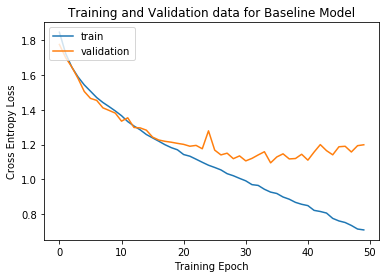

In [45]:
#print(history_transfer.history.keys())
plot_model_history(history_transfer, save_file = "transfer.png")

In [46]:
print('Test accuracy: %.4f%%' % get_model_accuracy(model_final, test_tensors_transf, test_targets_transf))

Test accuracy: 62.9005%


In [47]:
predictions_np = get_predictions_tensor(model_final, test_tensors_transf)
print("Average categorical cross entropy is: ", manual_total_cce(predictions_np, test_targets_transf))

Average categorical cross entropy is:  1.0503048542716762


## Robustness Analysis

Below, the robustness of the final VGG-19 transfer learning model will be investigated. To do so, random Gaussian noise will be added to a number of images, and the performance of the classifier will be compared with when clean images were used.

In [21]:
def onehot_to_label(one_hot_array, labels_array):
    for i in range(len(one_hot_array)):
        if one_hot_array[i] == 1:
            break
    return labels_array[i]

(25120, 48, 48, 3)


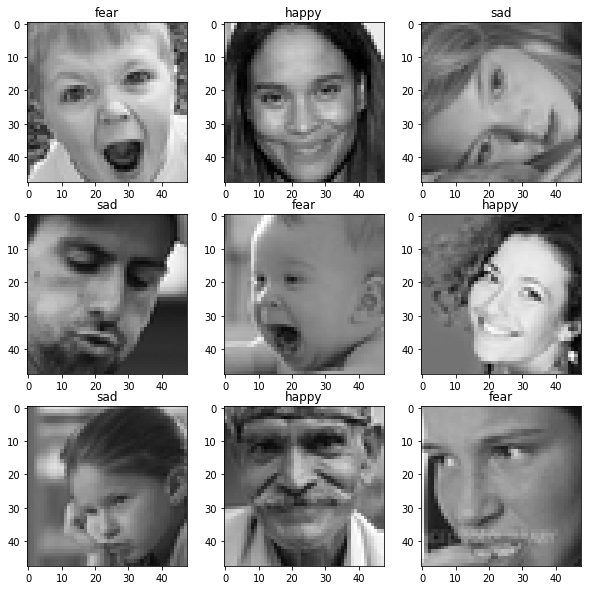

In [23]:
# Visualization of adding noise

samples = train_tensors_transf
seed_number = 0
print(samples.shape)
fig = plt.figure(figsize=(10, 10))
num_rows = 3
num_columns = 3
labels_words = ['angry', 'disgust', 'fear', 'happy', 'sad', 'surprise', 'neutral']
labels = train_targets_transf

for i in range(num_rows*num_columns):
    ax = fig.add_subplot(num_rows,num_columns,i + 1)
    ax.imshow(samples[seed_number + i])
    ax.set_title(onehot_to_label(labels[seed_number + i], labels_words))

In [25]:
def add_noise(samples, number_of_images, std_dev=0.025, seed_number=0):
    
    # Examine each pixel value
    for i in range(number_of_images):
        for pixel_x in samples[seed_number+i]:
            for pixel_y in range(len(pixel_x)):
                # Generate random Gaussian noise
                noise_ = np.random.normal(0,std_dev,1)[0]
                for rgb_value in range(len(pixel_x[pixel_y])):
                    pixel_x[pixel_y][rgb_value] += noise_
                    # Normalize out-of-range values
                    if pixel_x[pixel_y][rgb_value] < 0:
                        pixel_x[pixel_y][rgb_value] = 0
                    if pixel_x[pixel_y][rgb_value] > 1:
                        pixel_x[pixel_y][rgb_value] = 1
    
    return samples

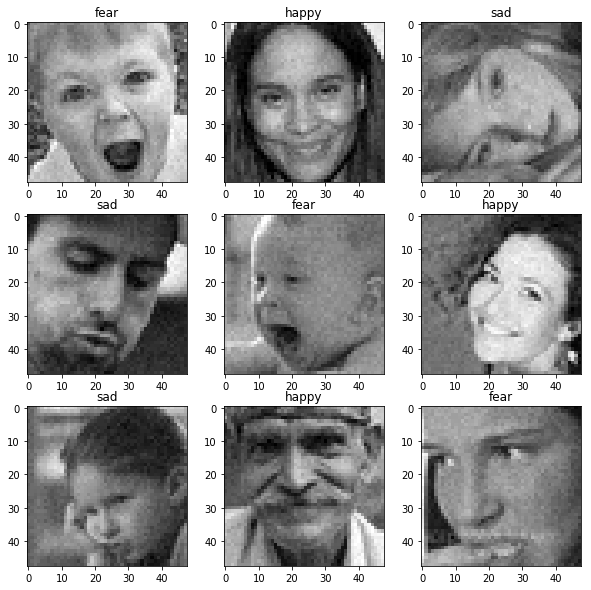

In [26]:
# Visualize the effect of adding a small amount of gaussian noise to the samples
samples_noise = np.copy(train_tensors_transf)
fig = plt.figure(figsize=(10, 10))

# Change this value to get varying noise
noise_std_dev = 0.025
samples_noise = add_noise(samples_noise, num_rows*num_columns, std_dev = noise_std_dev)             
    
for i in range(num_rows*num_columns):
    ax = fig.add_subplot(num_rows,num_columns,i + 1)
    ax.imshow(samples_noise[seed_number + i])
    ax.set_title(onehot_to_label(labels[seed_number + i], labels_words))

In [57]:
# add the gaussian noise to each of the test_tensors_transf
test_tensors_transf_noise = np.copy(test_tensors_transf)
num_images = test_tensors_transf_noise.shape[0]
test_tensors_transf_noise = add_noise(test_tensors_transf_noise, num_images, std_dev = noise_std_dev)

In [58]:
predictions_np = get_predictions_tensor(model_final, test_tensors_transf_noise)
print("Categorical Cross Entropy Loss with noise added: ", manual_total_cce(predictions_np, test_targets_transf))

Categorical Cross Entropy Loss with noise added:  1.108950010054795


In [59]:
print("Accuracy with noise added: ", get_model_accuracy(model_final, test_tensors_transf_noise, test_targets_transf))

Accuracy with noise added:  60.6297018668
